In [ ]:
!curl https://cs231n.stanford.edu/tiny-imagenet-200.zip -o tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

In [49]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [50]:
random.seed(42)

In [2]:
os.listdir("tiny-imagenet-200")

['test', 'train', 'val', 'wnids.txt', 'words.txt']

In [21]:
with open("tiny-imagenet-200/words.txt") as f:
    words = f.read().strip().split("\n")
    word_dict = {}
    for word in words:
        word_id, word = word.split("\t")
        word_dict[word_id] = word

print(len(word_dict))

82115


In [65]:
random.sample(list(word_dict.items()), 5)

[('n10945546', 'Duns Scotus, John Duns Scotus'),
 ('n08857405', 'Sao Louis'),
 ('n03868763', 'oxyacetylene torch'),
 ('n09019592', 'Adzhar, Adzharia'),
 ('n08588486', 'belly')]

In [22]:
with open("tiny-imagenet-200/wnids.txt") as f:
    wnids = f.read().strip().split("\n")
print(wnids[:5])
print(len(wnids))

['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582']
200


In [46]:
image_dirs = [os.path.join("tiny-imagenet-200/train", wnid, "images") for wnid in wnids]
image_files = [os.path.join(img_dir, img_file) for img_dir in image_dirs for img_file in os.listdir(img_dir)]
image_files[:5]

['tiny-imagenet-200/train\\n02124075\\images\\n02124075_0.JPEG',
 'tiny-imagenet-200/train\\n02124075\\images\\n02124075_1.JPEG',
 'tiny-imagenet-200/train\\n02124075\\images\\n02124075_10.JPEG',
 'tiny-imagenet-200/train\\n02124075\\images\\n02124075_100.JPEG',
 'tiny-imagenet-200/train\\n02124075\\images\\n02124075_101.JPEG']

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


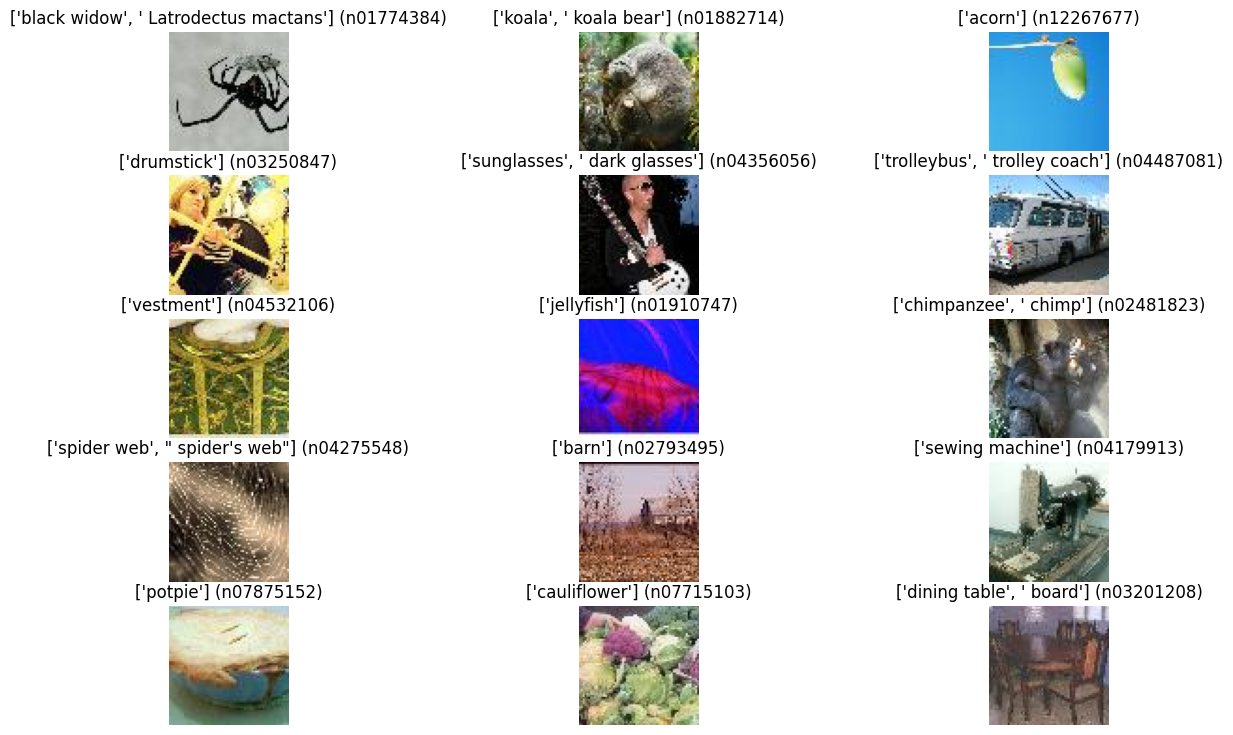

In [74]:
fig, ax = plt.subplots(5, 3, figsize=(15,9))
for i in range(5):
    for j in range(3):
        random_idx = random.randint(0, len(image_files) - 1)
        img_path = image_files[random_idx]
        img = mpimg.imread(img_path)
        print(img.shape)
        ax[i, j].imshow(img)
        ax[i, j].axis('off')
        wnid = img_path.split(os.sep)[-3]
        ax[i, j].set_title(f"{word_dict[wnid].split(',')[:2]} ({wnid})")
       
        

In [99]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader


class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # Load class list
        wnids_path = os.path.join(root_dir, "wnids.txt")
        with open(wnids_path, "r") as f:
            wnids = [x.strip() for x in f.readlines()]
        self.class_to_idx = {wnid: i for i, wnid in enumerate(wnids)}

        if split == "train":
            self._load_train()
        else:
            self._load_val()

    def _load_train(self):
        train_dir = os.path.join(self.root_dir, "train")
        for wnid in os.listdir(train_dir):
            img_dir = os.path.join(train_dir, wnid, "images")
            if not os.path.isdir(img_dir):
                continue
            for fname in os.listdir(img_dir):
                if fname.endswith(".JPEG"):
                    self.image_paths.append(os.path.join(img_dir, fname))
                    self.labels.append(self.class_to_idx[wnid])

    def _load_val(self):
        val_dir = os.path.join(self.root_dir, "val")
        anno_path = os.path.join(val_dir, "val_annotations.txt")
        img_dir = os.path.join(val_dir, "images")

        # Parse annotations
        annotations = {}
        with open(anno_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split("\t")
                if len(parts) >= 2:
                    annotations[parts[0]] = parts[1]

        for fname in os.listdir(img_dir):
            if fname.endswith(".JPEG") and fname in annotations:
                wnid = annotations[fname]
                if wnid in self.class_to_idx:
                    self.image_paths.append(os.path.join(img_dir, fname))
                    self.labels.append(self.class_to_idx[wnid])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [72]:
from torchvision import transforms

# ImageNet-like normalization
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.480, 0.448, 0.397), (0.277, 0.269, 0.282))
])

val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.480, 0.448, 0.397), (0.277, 0.269, 0.282))
])
train_dataset = TinyImageNetDataset(root_dir="tiny-imagenet-200", split="train", transform=train_transform)
val_dataset = TinyImageNetDataset(root_dir="tiny-imagenet-200", split="val", transform=val_transform)

In [73]:
""" 
Information about architecture config:
Tuple is structured by (kernel_size, filters, stride, padding) 
"M" is simply maxpooling with stride 2x2 and kernel 2x2
List is structured by tuples and lastly int with number of repeats
"""

architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


In [ ]:
import torch
import torch.nn as nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(0.1)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class CustomCNN(nn.Module):
    def __init__(self, architecture_config, in_channels=3, input_size=64, num_classes=200, fc_layers=None, dropout=0.5, **kwargs):
        super(CustomCNN, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.input_size = input_size
        self.num_classes = num_classes
        
        self.network = self._create_conv_layers(self.architecture)
        
        self.fc_layers = fc_layers if fc_layers else [512]
        self.flat_size = self._calculate_flat_size()
        self.dropout = dropout # Dropout for FC layers
        
        self.fcs = self._create_fc_layers(**kwargs)
        print(self.fcs)


    def forward(self,x):
        x = self.network(x)
        return self.fcs(torch.flatten(x, start_dim=1))
    
    def _calculate_flat_size(self):
        """Calculate flattened size by passing dummy input through conv layers"""
        dummy_input = torch.zeros(1, self.in_channels, self.input_size, self.input_size)
        dummy_output = self.network(dummy_input)
        return dummy_output.view(1, -1).shape[1]
    
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(in_channels, out_channels = x[1], kernel_size=x[0], stride=x[2], padding=x[3],)]
                in_channels = x[1]

            if type(x) == str:
                layers += [
                    nn.MaxPool2d(kernel_size=2, stride=2)]

            if type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(in_channels, out_channels = conv1[1], kernel_size= conv1[0], stride=conv1[2], padding=conv1[3],)]
                    layers += [
                        CNNBlock(conv1[1], out_channels = conv2[1], kernel_size= conv2[0], stride=conv2[2], padding=conv2[3],)]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)
    
    def _create_fc_layers(self):
        """Build FC layers dynamically based on flat_size and fc_layers config"""
        layers = []
        layer_sizes = [self.flat_size] + self.fc_layers + [self.num_classes]
        
        # Create all layers except the last one with activation and dropout
        for i in range(len(layer_sizes) - 2):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.LeakyReLU(0.1))
            layers.append(nn.Dropout(self.dropout))
        
        # Last layer: no activation (will use with CrossEntropyLoss)
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        
        return nn.Sequential(*layers)



In [115]:
TINY_IMAGENET_ARCH = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 2],
    (3, 1024, 1, 1),
    "M",
]

In [116]:
# Re-write train_model to implement Validation loop and finally use test_model to evaluate the model
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        
        # ---- Validation Phase ----
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Compute accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.2f}%")


Train Model with 

In [117]:
model_tiny_imagenet = CustomCNN(
    architecture_config=TINY_IMAGENET_ARCH,
    in_channels=3,
    input_size=64,
    num_classes=200,
    fc_layers=[512, 256]
)

[Linear(in_features=4096, out_features=512, bias=True), LeakyReLU(negative_slope=0.1), Dropout(p=0.5, inplace=False), Linear(in_features=512, out_features=256, bias=True), LeakyReLU(negative_slope=0.1), Dropout(p=0.5, inplace=False), Linear(in_features=256, out_features=200, bias=True)]


In [118]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tiny_imagenet.parameters(), lr=0.001)

train_model(model_tiny_imagenet, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, num_epochs=5)

TypeError: 'list' object is not callable

In [ ]:
train_loader.

AttributeError: 'DataLoader' object has no attribute '_iter_'